### Turbidity Estimation using test set sampled images

In [1]:
%matplotlib widget
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import numpy as np
import collections
import glob
import os
import sys 
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
sys.path.insert(0, '../dip_utils')
from matrix_utils import arr_info
from vis_utils import (vis_pair, 
                       vis_triple)
%run watershed.ipynb
%run calibrate.ipynb
%run greyscale.ipynb
%run image_stacking.ipynb
%run whitep_elimination.ipynb
%run skew_correction.ipynb

In [2]:
path = '../test_images/'
dest = '../stacked_test/'
clear = '../stacked_new/NTU0.jpg'

In [3]:
%%bash
cd ../stacked_test/
rm -r *

In [4]:
image_stacking(path, dest)

In [5]:
image = []
filename = []
for dic in os.listdir(dest):
    if dic != '.ipynb_checkpoints':
        filename.append(dic)
for dic in os.listdir(dest):
    d = os.path.join(dest, dic)  # directory of water samples
    if not d.endswith('.ipynb_checkpoints'):
        img = plt.imread(d)
        image.append(img)

In [6]:
img_lib = {}
for i in range(len(filename)):
    img_lib[filename[i]] = image[i]

In [7]:
markers_lib = dict()
for img in img_lib:
    markers = watershed(dest, img)
    markers_lib[img] = markers

In [8]:
bottom_lib = dict()
left_lib = dict()
top_lib = dict()
right_lib = dict()

In [9]:
# Acquire the bottom and the leftmost point of the ROI
for key in markers_lib:
    bottom = np.where(markers_lib[key]==1)[0].max()
    bottom_lib[key] = bottom
    left = np.where((markers_lib[key]!=1) & (markers_lib[key]!=-1))[1].min()
    left_lib[key] = left
    top = np.where(markers_lib[key]==2)[0].min()
    top_lib[key] = top
    right = np.where((markers_lib[key]!=1) & (markers_lib[key]!=-1))[1].max()
    right_lib[key] = right

In [10]:
# Some threshold values
envir = ['NTU19_0.jpg', 'NTU3_18.jpg', 'NTU4_05.jpg']
# 550 50 80 350
vert_thres = 500
horz_thres = 50
length = 80
dist = 330

In [11]:
# Avoid Extracting incorrect ROI
for key in markers_lib:
    while markers_lib[key][bottom_lib[key]-vert_thres, left_lib[key]+horz_thres] == 1:
        left_lib[key] += horz_thres
    # if key in envir:
    #     left_lib[key] += 3*horz_thres
left_lib

{'NTU164.jpg': 192,
 'NTU74_5.jpg': 260,
 'NTU236.jpg': 193,
 'NTU137.jpg': 153,
 'NTU50_5.jpg': 210,
 'NTU35_2.jpg': 205,
 'NTU334.jpg': 241,
 'NTU263.jpg': 253,
 'NTU185.jpg': 222,
 'NTU358.jpg': 121,
 'NTU214.jpg': 224,
 'NTU160.jpg': 166,
 'NTU65_3.jpg': 78,
 'NTU374.jpg': 208,
 'NTU43_3.jpg': 204,
 'NTU148.jpg': 209,
 'NTU127.jpg': 120,
 'NTU323.jpg': 131,
 'NTU109.jpg': 199,
 'NTU296.jpg': 158,
 'NTU417.jpg': 183}

In [12]:
# Corners: Top left, Top right, Bottom left, Bottom right
src_corners = dict()
for key in markers_lib:
    corners = []
    tl = [left_lib[key], top_lib[key]]
    tr = [right_lib[key], top_lib[key]]
    bl = [left_lib[key], bottom_lib[key]]
    br = [right_lib[key], bottom_lib[key]]
    corners.append(tl)
    corners.append(tr)
    corners.append(bl)
    corners.append(br)
    src_corners[key] = (corners)

In [13]:
dst_corners = dict()
for key in markers_lib:
    dst_corners[key] = get_destination_points(src_corners[key])

In [14]:
# Calibration
calibrated = {}
for img in img_lib:
    org = plt.imread(os.path.join(dest, img))
    org = lab_trans(clear, org)
    calibrated[img] = org

In [15]:
greyscale = {}
for img in img_lib:
    grey = calibrated[img]
    grey = to_single_channel(grey)
    greyscale[img] = grey

In [16]:
deskewed_lib = dict()
dimensions = dict()
for key in greyscale:
    deskewed = unwarp(dest, key, np.float32(src_corners[key]), dst_corners[key][0])
    dimensions[key] = (dst_corners[key][1], dst_corners[key][2])
    deskewed_lib[key] = deskewed

In [17]:
greyscale = {}
for img in deskewed_lib:
    grey = deskewed_lib[img]
    grey = to_single_channel(grey)
    greyscale[img] = grey

In [18]:
# x_left represents the ROI of the reference, while x_right represents the ROI of the sample
x_left = []
x_right = []
y_left = []
y_right = []

In [19]:
for key in deskewed_lib:
    x = []
    x1 = []
    y = []
    y1 = []
    for i in range(dst_corners[key][1], dst_corners[key][1]-vert_thres, -1):
        x.append(i)
        y.append(np.mean(deskewed_lib[key][i-1:i, horz_thres:horz_thres+length]))
    x_left.append(x)
    y_left.append(y)
    for i in range(dst_corners[key][1], dst_corners[key][1]-vert_thres, -1):
        x1.append(i)
        y1.append(np.mean(deskewed_lib[key][i-1:i, horz_thres+dist:
                                         horz_thres+dist+length]))
    x_right.append(x1)
    y_right.append(y1)

In [20]:
x_left = np.array(x_left)
x_right = np.array(x_right)
y_left = np.array(y_left)
y_right = np.array(y_right)

In [21]:
# plot the ratio with respect to NTU
num = []
for img in img_lib:
    img = img.replace('_', '.')
    a = img.split('NTU')
    a = [b.split('.jpg') for b in a]
    for item in a:
        item.remove("")
    num.append(a)

In [22]:
NTU = []
for i in num:
    for j in i:
        if len(j) != 0:
            NTU.append(float(j[0]))

In [23]:
f = open('../assets/theta.txt')
thresholds = f.readlines()
for i in range(len(thresholds)):
    thresholds[i] = thresholds[i].strip()
    thresholds[i] = float(thresholds[i])

In [24]:
diff = []
for i in range(x_left.shape[0]):
    diff.append(abs(np.mean(abs(y_right[i] - y_left[i]))))

In [25]:
for i in range(len(diff)):
    diff[i] -= thresholds[0]

In [26]:
correction = abs(thresholds[2] / thresholds[1])
correction

9.230273012056061

In [27]:
estimated = [abs(round(diff[i]*thresholds[1]+thresholds[2], 2)) for i in range(len(diff))]

In [28]:
pair = dict(zip(NTU, estimated))

In [29]:
od_NTU = []
od_estimated = []
for key, value in sorted(pair.items()):
    od_NTU.append(key)
    od_estimated.append(value)

In [30]:
r2 = r2_score(od_NTU, od_estimated)
r2 = round(r2, 3)

In [31]:
df = pd.DataFrame(list(zip(od_NTU, od_estimated)),
               columns =['Actual_NTU', 'Estimated_NTU'])

In [32]:
df['R^2'] = r2
df

,Actual_NTU,Estimated_NTU,R^2
0,35.2,28.02,0.975
1,43.3,67.26,0.975
2,50.5,58.13,0.975
3,65.3,48.46,0.975
4,74.5,68.12,0.975
5,109.0,120.85,0.975
6,127.0,154.40,0.975
7,137.0,168.61,0.975
8,148.0,181.81,0.975
9,160.0,137.86,0.975


In [33]:
df.to_csv('../assets/prediction.csv')

In [34]:
# Figure 10
model = ols('Estimated_NTU ~ Actual_NTU', data=df).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Estimated_NTU   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     810.8
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           4.78e-17
Time:                        13:48:06   Log-Likelihood:                -89.881
No. Observations:                  21   AIC:                             183.8
Df Residuals:                      19   BIC:                             185.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4813      7.886      0.949      0.3

In [35]:
# # Figure 9
# #define figure size
# fig = plt.figure(figsize=(12,8))

# #produce regression plots
# fig = sm.graphics.plot_regress_exog(model, 'Actual_NTU', fig=fig)
# plt.savefig('../assets/test_fit.pdf', dpi=600)
# plt.show()

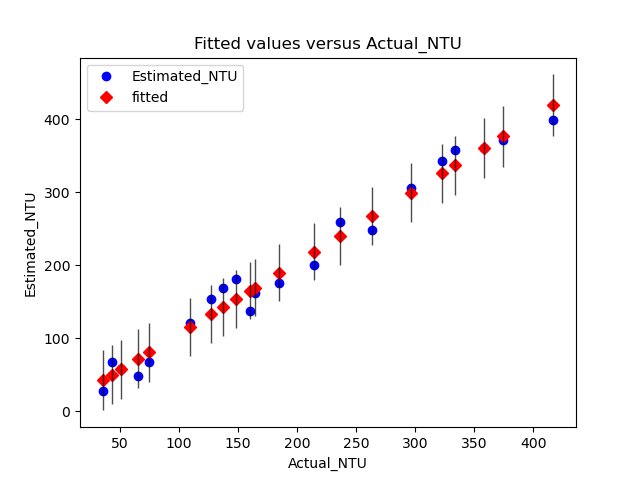

In [36]:
fig, ax = plt.subplots()

#produce regression plots
#fig = sm.graphics.plot_regress_exog(model, 'pixel_intensity', fig=fig)
fig = sm.graphics.plot_fit(model, 'Actual_NTU', ax=ax)
plt.savefig('../assets/test_fit.pdf', dpi=600)